# Machine v4 — Hybrid Training (Full-feature + URL-only Fallback)


1) **Full-feature model** (menggunakan fitur lengkap dari CSV PhiUSIIL) → dipakai jika URL input ditemukan di dataset  
2) **URL-only model** (subset + fitur kebaruan, dihitung dari string URL memakai `tldextract`) → dipakai jika URL input **tidak ada** di dataset  

## Output artifacts (folder `artifacts/`)
### Full-feature
- `model_pipeline.joblib`
- `feature_schema.json`
- `best_threshold.json`
- `metrics.json`
- `versions_full.json`
- `feature_dict_full.json`

### URL-only
- `model_urlonly.joblib`
- `feature_schema_urlonly.json`
- `best_threshold_urlonly.json`
- `metrics_urlonly.json`
- `versions_urlonly.json`
- `feature_dict_urlonly.json`

> Label asli dataset: `0=phishing`, `1=legitimate`.  
Kita pakai **positive class = phishing** → `y = (label==0).astype(int)` sehingga `predict_proba()[:,1]` = **P(phishing)**.


In [1]:
# Install (jika perlu):
# !pip install -U pandas numpy scikit-learn joblib xgboost tldextract matplotlib

import os, json, math, re, ipaddress
from pathlib import Path
from urllib.parse import urlparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tldextract
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

from xgboost import XGBClassifier

OUT_DIR = Path("artifacts")
OUT_DIR.mkdir(exist_ok=True)

# tldextract: snapshot internal, no network fetch
_TLD = tldextract.TLDExtract(suffix_list_urls=None)


In [2]:
# ===== Locate dataset CSV (lokal) =====
CANDIDATES = [
    Path("dataset") / ("PhiUSIIL_Phishing_URL_Dataset.csv")
]

dataset_path = None
for p in CANDIDATES:
    if p.exists():
        dataset_path = p
        break

if dataset_path is None:
    for folder in [Path("dataset"), Path("data")]:
        if folder.exists():
            csvs = sorted(folder.glob("*.csv"))
            if csvs:
                dataset_path = csvs[0]
                break

dataset_path


WindowsPath('dataset/PhiUSIIL_Phishing_URL_Dataset.csv')

In [3]:
df = pd.read_csv(dataset_path)
print("Shape:", df.shape)
print("Columns:", len(df.columns))
df.head(3)


Shape: (235795, 56)
Columns: 56


,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1


In [4]:
# Target: positive class = phishing
if "label" not in df.columns:
    raise ValueError("Kolom 'label' tidak ditemukan.")

y = (df["label"].astype(int) == 0).astype(int)  # 1=phishing
print("Distribusi y (1=phishing):")
print(pd.Series(y).value_counts(normalize=True))

# Features for full-feature training: drop non-informative columns
drop_cols = [c for c in ["label", "URL", "FILENAME", "Title", "Domain"] if c in df.columns]
X_full = df.drop(columns=drop_cols)
print("X_full:", X_full.shape)


Distribusi y (1=phishing):
label
0    0.571895
1    0.428105
Name: proportion, dtype: float64
X_full: (235795, 51)


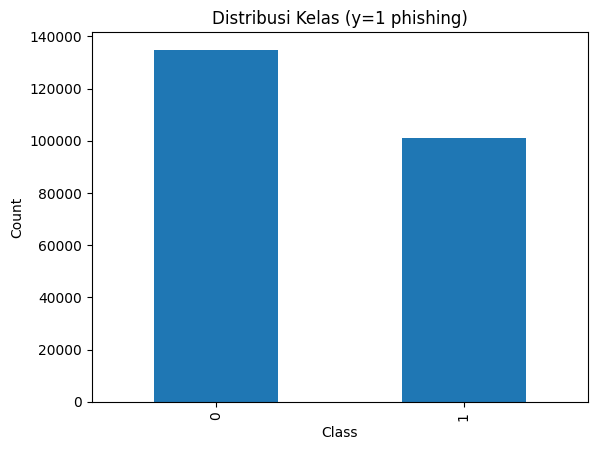

Top missing values:
URLLength               0
DomainLength            0
IsDomainIP              0
TLD                     0
URLSimilarityIndex      0
CharContinuationRate    0
TLDLegitimateProb       0
URLCharProb             0
TLDLength               0
NoOfSubDomain           0
HasObfuscation          0
NoOfObfuscatedChar      0
ObfuscationRatio        0
NoOfLettersInURL        0
LetterRatioInURL        0
dtype: int64


In [5]:
# ===== Quick EDA =====
plt.figure()
plt.title("Distribusi Kelas (y=1 phishing)")
pd.Series(y).value_counts().sort_index().plot(kind="bar")
plt.xlabel("Class"); plt.ylabel("Count")
plt.show()

missing = X_full.isna().sum().sort_values(ascending=False)
print("Top missing values:")
print(missing.head(15))


In [6]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42, stratify=y
)

# Column types
cat_cols = [c for c in X_full.columns if X_full[c].dtype == "object"]
num_cols = [c for c in X_full.columns if c not in cat_cols]

print("Categorical:", cat_cols[:20], "..." if len(cat_cols)>20 else "")
print("Numeric:", len(num_cols))


Categorical: [] 
Numeric: 51


In [7]:
# Preprocess
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

num_pipe_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

num_pipe_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

pre_lr = ColumnTransformer([("cat", cat_pipe, cat_cols), ("num", num_pipe_lr, num_cols)])
pre_tree = ColumnTransformer([("cat", cat_pipe, cat_cols), ("num", num_pipe_tree, num_cols)])


In [8]:
# Models (Full-feature)
lr = LogisticRegression(max_iter=2500, class_weight="balanced")
rf = RandomForestClassifier(
    n_estimators=600, random_state=42, class_weight="balanced_subsample", n_jobs=-1
)
xgb = XGBClassifier(
    n_estimators=700,
    learning_rate=0.06,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
)

pipes_full = {
    "LogReg": Pipeline([("prep", pre_lr), ("clf", lr)]),
    "RandomForest": Pipeline([("prep", pre_tree), ("clf", rf)]),
    "XGBoost": Pipeline([("prep", pre_tree), ("clf", xgb)]),
}


In [9]:
# Metrics helpers
def eval_at_threshold(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    return {
        "accuracy": float(accuracy_score(y_true, pred)),
        "precision": float(precision_score(y_true, pred, zero_division=0)),
        "recall": float(recall_score(y_true, pred, zero_division=0)),
        "f1": float(f1_score(y_true, pred, zero_division=0)),
    }

def best_threshold_by_f1(y_true, proba):
    best = {"thr": 0.5, "f1": -1.0}
    for thr in np.linspace(0.05, 0.95, 91):
        m = eval_at_threshold(y_true, proba, thr)
        if m["f1"] > best["f1"]:
            best = {"thr": float(thr), "f1": float(m["f1"]), **m}
    return best


In [10]:
# Train + evaluate full-feature models

# Recompute column types to avoid non-numeric columns in numeric pipeline
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

pre_lr = ColumnTransformer([("cat", cat_pipe, cat_cols), ("num", num_pipe_lr, num_cols)])
pre_tree = ColumnTransformer([("cat", cat_pipe, cat_cols), ("num", num_pipe_tree, num_cols)])

pipes_full = {
    "LogReg": Pipeline([("prep", pre_lr), ("clf", lr)]),
    "RandomForest": Pipeline([("prep", pre_tree), ("clf", rf)]),
    "XGBoost": Pipeline([("prep", pre_tree), ("clf", xgb)]),
}

results_full = []
threshold_full = {}

for name, pipe in pipes_full.items():
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]  # P(phishing)
    auc = float(roc_auc_score(y_test, proba))
    thr = best_threshold_by_f1(y_test, proba)
    threshold_full[name] = {"roc_auc": auc, "best_threshold_by_f1": thr["thr"], "metrics_at_best_thr": thr}
    results_full.append({
        "model": name,
        "roc_auc": auc,
        "best_thr_f1": thr["thr"],
        "f1": thr["f1"],
        "precision": thr["precision"],
        "recall": thr["recall"],
        "accuracy": thr["accuracy"],
    })

df_full = pd.DataFrame(results_full).sort_values(by=["f1","roc_auc"], ascending=False)
df_full


,model,roc_auc,best_thr_f1,f1,precision,recall,accuracy
0,LogReg,1.0,0.13,1.0,1.0,1.0,1.0
1,RandomForest,1.0,0.40,1.0,1.0,1.0,1.0
2,XGBoost,1.0,0.05,1.0,1.0,1.0,1.0


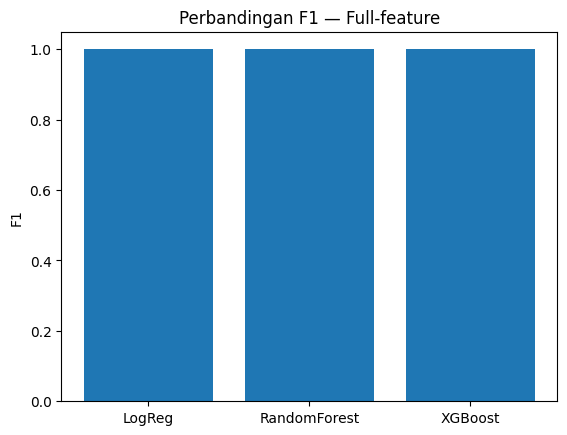

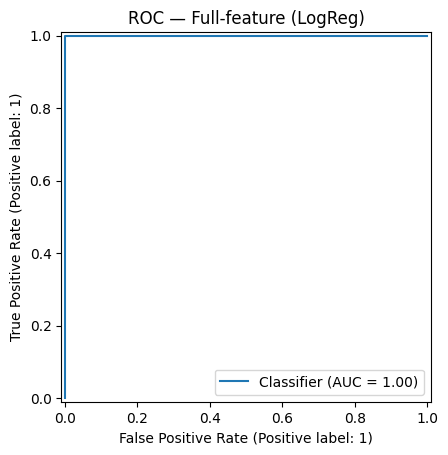

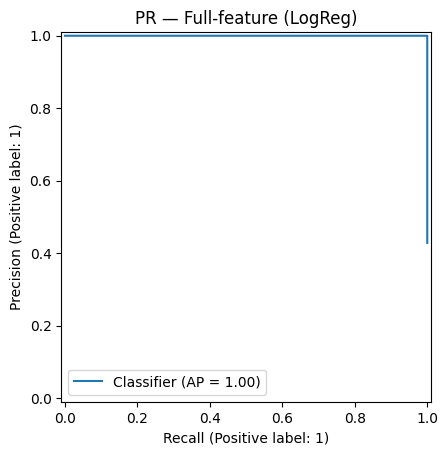

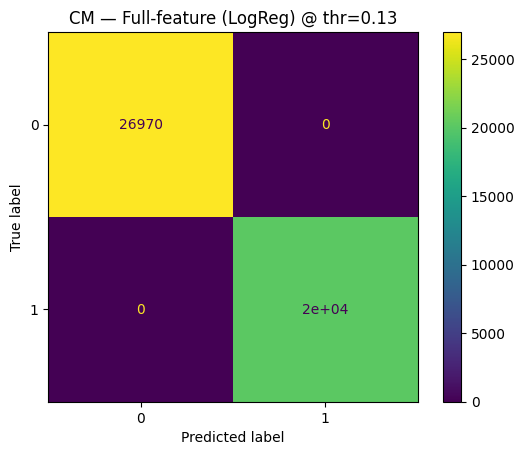

Best full-feature model: LogReg thr: 0.13


In [11]:
# Plot comparison (F1)
plt.figure()
plt.title("Perbandingan F1 — Full-feature")
plt.bar(df_full["model"], df_full["f1"])
plt.ylabel("F1")
plt.show()

best_full_name = df_full.iloc[0]["model"]
best_full_pipe = pipes_full[best_full_name]
best_full_pipe.fit(X_train, y_train)
proba = best_full_pipe.predict_proba(X_test)[:, 1]
thr = threshold_full[best_full_name]["best_threshold_by_f1"]

RocCurveDisplay.from_predictions(y_test, proba)
plt.title(f"ROC — Full-feature ({best_full_name})")
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title(f"PR — Full-feature ({best_full_name})")
plt.show()

pred = (proba >= thr).astype(int)
cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(cm).plot()
plt.title(f"CM — Full-feature ({best_full_name}) @ thr={thr:.2f}")
plt.show()

print("Best full-feature model:", best_full_name, "thr:", thr)


In [12]:
# Export full-feature artifacts for Flask
best_full_name = df_full.iloc[0]["model"]
best_full_pipe = pipes_full[best_full_name]
best_full_pipe.fit(X_full, y)  # train on all

schema_full = {
    "used_features": list(X_full.columns),
    "categorical_cols": cat_cols,
    "numeric_cols": num_cols,
    "drop_cols": drop_cols,
    "note": "Full-feature; positive class = phishing (1); original label 0=phishing,1=legitimate",
}

# Create feature dictionary for full-feature model
feature_dict_full = {}
for col in X_full.columns:
    # Generic description based on column name
    feature_dict_full[col] = f"Feature: {col} (from PhiUSIIL dataset)"

# You can manually update descriptions for known features later
(OUT_DIR / "feature_dict_full.json").write_text(json.dumps(feature_dict_full, indent=2), encoding="utf-8")

thr_out_full = {
    "best_model": best_full_name,
    "best_threshold_by_f1": threshold_full[best_full_name]["best_threshold_by_f1"],
    "all_models": threshold_full,
}

metrics_out_full = {
    "test_summary": results_full,
    "best_model": best_full_name,
    "dataset_path": str(dataset_path),
}

(OUT_DIR / "feature_schema.json").write_text(json.dumps(schema_full, indent=2), encoding="utf-8")
(OUT_DIR / "best_threshold.json").write_text(json.dumps(thr_out_full, indent=2), encoding="utf-8")
(OUT_DIR / "metrics.json").write_text(json.dumps(metrics_out_full, indent=2), encoding="utf-8")
joblib.dump(best_full_pipe, OUT_DIR / "model_pipeline.joblib")

# Save versions (important to avoid sklearn mismatch)
import sklearn, xgboost, joblib as jb
versions_full = {
    "python": __import__("sys").version,
    "scikit_learn": sklearn.__version__,
    "xgboost": xgboost.__version__,
    "joblib": jb.__version__,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "tldextract": tldextract.__version__,
}
(OUT_DIR / "versions_full.json").write_text(json.dumps(versions_full, indent=2), encoding="utf-8")

print("Saved full-feature artifacts to", OUT_DIR)
print(f"- feature_dict_full.json ({len(feature_dict_full)} features)")

Saved full-feature artifacts to artifacts
- feature_dict_full.json (51 features)


---

## Bagian 2 — URL-only + Fitur Kebaruan (Hybrid Fallback)

Tujuan: model yang **tidak bergantung fitur HTML** supaya bisa memprediksi URL eksternal.


In [13]:
# ===== URL-only feature engineering =====
def normalize_url(u: str) -> str:
    if u is None:
        return ""
    u = str(u).strip().replace(" ", "")
    u = u.lower()
    if len(u) > 1 and u.endswith("/"):
        u = u[:-1]
    return u

def shannon_entropy(s: str) -> float:
    if not s:
        return 0.0
    freq = {}
    for ch in s:
        freq[ch] = freq.get(ch, 0) + 1
    n = len(s)
    ent = 0.0
    for c in freq.values():
        p = c / n
        ent -= p * math.log2(p)
    return float(ent)

SHORTENER_DOMAINS = {
    "bit.ly", "tinyurl.com", "t.co", "goo.gl", "is.gd", "cutt.ly", "buff.ly",
    "rebrand.ly", "ow.ly", "lnkd.in", "rb.gy"
}

SUSPICIOUS_KEYWORDS = [
    "login", "verify", "verification", "secure", "account", "update", "confirm",
    "signin", "sign-in", "bank", "payment", "wallet", "support", "webscr", "password"
]

def compute_urlonly_features(url: str) -> dict:
    u = normalize_url(url)
    parsed = urlparse(u if re.match(r"^https?://", u) else ("http://" + u))
    scheme = parsed.scheme or ""
    netloc = parsed.netloc or ""
    path = parsed.path or ""
    query = parsed.query or ""

    if "@" in netloc:
        netloc = netloc.split("@", 1)[1]

    host = netloc
    has_port = 0
    if ":" in host:
        if host.startswith("[") and "]" in host:
            h = host.split("]")[0].lstrip("[")
            rest = host.split("]")[1]
            if rest.startswith(":"):
                has_port = 1
            host = h
        else:
            parts = host.split(":")
            host = parts[0]
            has_port = 1

    ext = _TLD(host)
    tld = (ext.suffix or "").lower()
    subdomain = (ext.subdomain or "").lower()
    domain = (ext.domain or "").lower()

    url_len = len(u)
    domain_full = ".".join([p for p in [domain, tld] if p])
    domain_len = len(domain_full)

    is_https = 1 if scheme.lower() == "https" else 0

    is_domain_ip = 0
    try:
        ipaddress.ip_address(host)
        is_domain_ip = 1
    except Exception:
        is_domain_ip = 0

    n_sub = 0 if subdomain.strip() == "" else len([x for x in subdomain.split(".") if x])

    letters = sum(ch.isalpha() for ch in u)
    digits = sum(ch.isdigit() for ch in u)
    specials = max(url_len - letters - digits, 0)

    letter_ratio = letters / url_len if url_len else 0.0
    digit_ratio = digits / url_len if url_len else 0.0
    special_ratio = specials / url_len if url_len else 0.0

    lower = u.lower()
    kw_hits = 0
    kw_flags = {}
    for kw in SUSPICIOUS_KEYWORDS:
        hit = 1 if kw in lower else 0
        kw_flags[f"kw_{re.sub(r'[^a-z0-9]+','_',kw)}"] = hit
        kw_hits += hit

    feats = {
        "url_length": url_len,
        "domain_length": domain_len,
        "is_https": is_https,
        "is_domain_ip": is_domain_ip,
        "tld": tld if tld else "unknown",
        "tld_length": len(tld) if tld else 0,
        "num_subdomains": n_sub,
        "has_port": has_port,
        "path_length": len(path),
        "query_length": len(query),
        "letters_count": letters,
        "digits_count": digits,
        "specials_count": specials,
        "letter_ratio": letter_ratio,
        "digit_ratio": digit_ratio,
        "special_ratio": special_ratio,
        "count_dot": u.count("."),
        "count_hyphen": u.count("-"),
        "count_at": u.count("@"),
        "count_qmark": u.count("?"),
        "count_equal": u.count("="),
        "count_ampersand": u.count("&"),
        "count_percent": u.count("%"),
        "count_slash": u.count("/"),
        "count_underscore": u.count("_"),
        "count_hash": u.count("#"),
        "has_punycode": 1 if "xn--" in u else 0,
        "url_entropy": shannon_entropy(u),
        "is_shortener": 1 if domain_full in SHORTENER_DOMAINS else 0,
        "suspicious_kw_count": kw_hits,
    }
    feats.update(kw_flags)
    return feats

urls = df["URL"].astype(str).fillna("").tolist()
X_url = pd.DataFrame([compute_urlonly_features(u) for u in urls])
print("X_url shape:", X_url.shape)
X_url.head(3)


X_url shape: (235795, 45)


,url_length,domain_length,is_https,is_domain_ip,tld,tld_length,num_subdomains,has_port,path_length,query_length,...,kw_update,kw_confirm,kw_signin,kw_sign_in,kw_bank,kw_payment,kw_wallet,kw_support,kw_webscr,kw_password
0,32,20,1,0,com,3,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,24,12,1,0,de,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30,18,1,0,co.uk,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Save feature dictionary (makna singkat) untuk dipakai app.py
feature_dict_urlonly = {
  "url_length": "Panjang URL (jumlah karakter)",
  "domain_length": "Panjang domain+TLD (mis: example.com)",
  "is_https": "Apakah menggunakan HTTPS (1/0)",
  "is_domain_ip": "Apakah host berupa IP address (1/0)",
  "tld": "Top Level Domain (hasil tldextract)",
  "tld_length": "Panjang TLD",
  "num_subdomains": "Jumlah subdomain",
  "has_port": "Ada port eksplisit (:443) (1/0)",
  "path_length": "Panjang path URL",
  "query_length": "Panjang query string",
  "letters_count": "Jumlah huruf",
  "digits_count": "Jumlah digit",
  "specials_count": "Jumlah karakter selain huruf/digit",
  "letter_ratio": "Rasio huruf terhadap panjang URL",
  "digit_ratio": "Rasio digit terhadap panjang URL",
  "special_ratio": "Rasio special char terhadap panjang URL",
  "count_dot": "Jumlah '.'",
  "count_hyphen": "Jumlah '-'",
  "count_at": "Jumlah '@' (sering dipakai untuk obfuscation)",
  "count_qmark": "Jumlah '?'",
  "count_equal": "Jumlah '='",
  "count_ampersand": "Jumlah '&'",
  "count_percent": "Jumlah '%'",
  "count_slash": "Jumlah '/'",
  "count_underscore": "Jumlah '_'",
  "count_hash": "Jumlah '#'",
  "has_punycode": "Mengandung 'xn--' (indikasi punycode/IDN) (1/0)",
  "url_entropy": "Shannon entropy URL (indikasi keacakan/obfuscation)",
  "is_shortener": "Domain termasuk URL shortener (1/0)",
  "suspicious_kw_count": "Jumlah keyword mencurigakan yang muncul",
}
for kw in SUSPICIOUS_KEYWORDS:
    feature_dict_urlonly[f"kw_{re.sub(r'[^a-z0-9]+','_',kw)}"] = f"Flag keyword '{kw}' muncul (1/0)"

(OUT_DIR / "feature_dict_urlonly.json").write_text(json.dumps(feature_dict_urlonly, indent=2), encoding="utf-8")
print("Saved feature_dict_urlonly.json")


Saved feature_dict_urlonly.json


In [15]:
# Train URL-only models
X_train, X_test, y_train, y_test = train_test_split(
    X_url, y, test_size=0.2, random_state=42, stratify=y
)

cat_cols = ["tld"]
num_cols = [c for c in X_url.columns if c not in cat_cols]

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

num_pipe_lr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

num_pipe_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

pre_lr = ColumnTransformer([("cat", cat_pipe, cat_cols), ("num", num_pipe_lr, num_cols)])
pre_tree = ColumnTransformer([("cat", cat_pipe, cat_cols), ("num", num_pipe_tree, num_cols)])

lr = LogisticRegression(max_iter=2000, class_weight="balanced")
rf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced_subsample", n_jobs=-1)
xgb = XGBClassifier(
    n_estimators=500, learning_rate=0.08, max_depth=6,
    subsample=0.85, colsample_bytree=0.85, reg_lambda=1.0,
    random_state=42, n_jobs=-1, eval_metric="logloss"
)

pipes_url = {
    "LogReg": Pipeline([("prep", pre_lr), ("clf", lr)]),
    "RandomForest": Pipeline([("prep", pre_tree), ("clf", rf)]),
    "XGBoost": Pipeline([("prep", pre_tree), ("clf", xgb)]),
}

results_url = []
threshold_url = {}

for name, pipe in pipes_url.items():
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]  # P(phishing)
    auc = float(roc_auc_score(y_test, proba))
    thr = best_threshold_by_f1(y_test, proba)
    threshold_url[name] = {"roc_auc": auc, "best_threshold_by_f1": thr["thr"], "metrics_at_best_thr": thr}
    results_url.append({
        "model": name,
        "roc_auc": auc,
        "best_thr_f1": thr["thr"],
        "f1": thr["f1"],
        "precision": thr["precision"],
        "recall": thr["recall"],
        "accuracy": thr["accuracy"],
    })

df_url = pd.DataFrame(results_url).sort_values(by=["f1","roc_auc"], ascending=False)
df_url


,model,roc_auc,best_thr_f1,f1,precision,recall,accuracy
2,XGBoost,0.998370,0.31,0.995404,0.998604,0.992223,0.996077
1,RandomForest,0.998028,0.58,0.994582,0.998055,0.991134,0.995377
0,LogReg,0.996466,0.40,0.991241,0.995950,0.986577,0.992536


In [16]:
# Export URL-only artifacts
best_url_name = df_url.iloc[0]["model"]
best_url_pipe = pipes_url[best_url_name]
best_url_pipe.fit(X_url, y)

schema_url = {
    "used_features": list(X_url.columns),
    "categorical_cols": ["tld"],
    "numeric_cols": [c for c in X_url.columns if c != "tld"],
    "note": "URL-only lexical + novelty; positive class = phishing (1)",
}

thr_out_url = {
    "best_model": best_url_name,
    "best_threshold_by_f1": threshold_url[best_url_name]["best_threshold_by_f1"],
    "all_models": threshold_url,
}

metrics_out_url = {
    "test_summary": results_url,
    "best_model": best_url_name,
}

(OUT_DIR / "feature_schema_urlonly.json").write_text(json.dumps(schema_url, indent=2), encoding="utf-8")
(OUT_DIR / "best_threshold_urlonly.json").write_text(json.dumps(thr_out_url, indent=2), encoding="utf-8")
(OUT_DIR / "metrics_urlonly.json").write_text(json.dumps(metrics_out_url, indent=2), encoding="utf-8")
joblib.dump(best_url_pipe, OUT_DIR / "model_urlonly.joblib")

# Save versions
import sklearn, xgboost, joblib as jb
versions_url = {
    "python": __import__("sys").version,
    "scikit_learn": sklearn.__version__,
    "xgboost": xgboost.__version__,
    "joblib": jb.__version__,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "tldextract": tldextract.__version__,
}
(OUT_DIR / "versions_urlonly.json").write_text(json.dumps(versions_url, indent=2), encoding="utf-8")

print("Saved URL-only artifacts to", OUT_DIR)


Saved URL-only artifacts to artifacts
